In [1]:

import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import random
import re
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /Users/Cyrille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Cyrille/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Cyrille/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-01-11 21:33:54.221677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
PATH_TO_EMOTIONS = "../data/emotions.csv"

In [3]:
emotions_data = pd.read_csv(PATH_TO_EMOTIONS)
emotions_data.head()

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness


In [4]:
emotions_data["label"].unique()

array(['anger', 'sadness', 'joy', 'love', 'fear', 'surprise'],
      dtype=object)

In [5]:
emotions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [6]:
# count total for each unique label
emotions_data["label"].value_counts()   

label
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64

In [7]:
emotions_data.shape

(20000, 2)

In [8]:
stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('\n', '', text) # remove new line characters
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove hyperlinks
    
    # remove any http words and href
    text = re.sub(r'http', '', text)
    text = re.sub(r'href', '', text)

    # tokenize text
    tokens = nltk.tokenize.word_tokenize(text)

    # remove stopwords
    tokens = [word for word in tokens if word not in stopwords]

    # lemmatize words 
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

In [9]:
emotions_data["text"] = emotions_data["text"].apply(clean_text)

In [10]:
emotions_data.head()

,text,label
0,feel pissed old friend friend,anger
1,ive found made huge difference especially fing...,anger
2,also feel unfortunate nearly reader going meet...,sadness
3,feel petty clairee,anger
4,used believe feeling like fear ignored suppres...,sadness


In [11]:
surprise = emotions_data[emotions_data["label"] == "surprise"]

In [12]:
surprise

,text,label
30,began feel curious tried percieve beneath pride,surprise
44,feel weird completely nothing,surprise
84,care care people disability targeted sensation...,surprise
141,hope keep handing book mormon feel impressed give,surprise
213,ive reading feeling pleasantly surprised find ...,surprise
...,...,...
19890,go around people act normal feel strange,surprise
19901,feel herpes coming would surprised point make ...,surprise
19915,like thing leave others feeling surprised deli...,surprise
19944,feel like monster make way rubble stunned body...,surprise


In [13]:
count_vectorizer = CountVectorizer()
a = count_vectorizer.fit_transform(emotions_data["text"])
a.shape

(20000, 15079)

In [14]:
texts = emotions_data["text"].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15100 unique tokens.


In [15]:
emotions_data["text"] = emotions_data["text"].apply(lambda x: tokenizer.texts_to_sequences([x])[0])

In [16]:
emotions_data.head()

,text,label
0,"[1, 401, 167, 43, 43]",anger
1,"[20, 220, 46, 902, 979, 172, 853, 1875, 579, 1...",anger
2,"[40, 1, 653, 1113, 625, 27, 676, 263, 2428, 12...",sadness
3,"[1, 551, 7534]",anger
4,"[222, 194, 2, 3, 479, 502, 3210, 37, 71, 95]",sadness


In [17]:
X, y = emotions_data["text"], emotions_data["label"]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 42)

In [20]:
x_train = pad_sequences(x_train, maxlen=100)
x_test = pad_sequences(x_test, maxlen=100)
x_val = pad_sequences(x_val, maxlen=100)


In [21]:
y_train[:2], y_test[:2], y_val[:2]

(252      joy
 18632    joy
 Name: label, dtype: object,
 10650       love
 2041     sadness
 Name: label, dtype: object,
 17353    sadness
 16081      anger
 Name: label, dtype: object)

In [22]:
label_encoder = LabelEncoder()

# transform the labels to integers and then to one-hot encoded

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)
y_val = to_categorical(y_val_encoded)


In [23]:
y_train_encoded[:10], y_test_encoded[:10], y_val_encoded[:10]

(array([2, 2, 1, 0, 3, 0, 0, 4, 2, 0]),
 array([3, 4, 2, 4, 0, 2, 3, 5, 4, 1]),
 array([4, 0, 4, 4, 5, 1, 2, 1, 2, 4]))

In [24]:
def build_model(word_index):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 128))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
model = build_model(word_index=word_index)

In [26]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128,validation_data=(x_val, y_val),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10


100/100 [==============================] - 34s 310ms/step - loss: 1.4902 - accuracy: 0.4344 - val_loss: 1.2385 - val_accuracy: 0.5706
Epoch 2/10
100/100 [==============================] - 32s 316ms/step - loss: 0.7295 - accuracy: 0.7514 - val_loss: 0.5449 - val_accuracy: 0.8416
Epoch 3/10
100/100 [==============================] - 33s 332ms/step - loss: 0.2367 - accuracy: 0.9266 - val_loss: 0.3135 - val_accuracy: 0.8966
Epoch 4/10
100/100 [==============================] - 32s 324ms/step - loss: 0.1065 - accuracy: 0.9664 - val_loss: 0.3089 - val_accuracy: 0.8938
Epoch 5/10
100/100 [==============================] - 33s 331ms/step - loss: 0.0591 - accuracy: 0.9823 - val_loss: 0.3237 - val_accuracy: 0.9006
Epoch 6/10
100/100 [==============================] - 33s 328ms/step - loss: 0.0410 - accuracy: 0.9865 - val_loss: 0.3408 - val_accuracy: 0.9019
Epoch 7/10
100/100 [==============================] - 32s 324ms/step - loss: 0.0338 - accuracy: 0.9892 - val_loss: 0.4235 - val_accuracy: 0.8

In [27]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss=history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

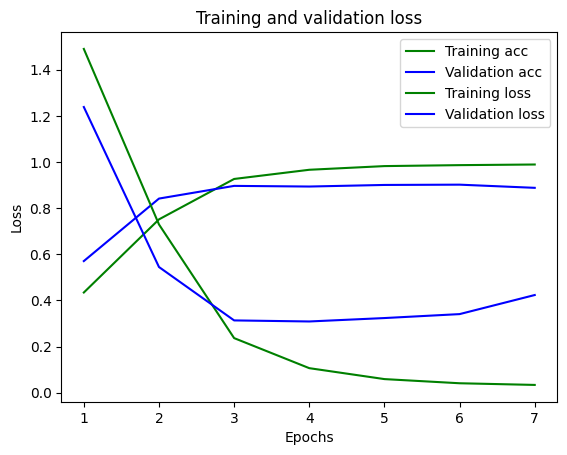

In [28]:
plot_history(history)

### Evaluate model with score on test data

In [29]:
model.evaluate(x_test, y_test)

125/125 [==============================] - 3s 20ms/step - loss: 0.3995 - accuracy: 0.8935


[0.39952218532562256, 0.8934999704360962]

In [30]:
preds = model.predict(x_test)

125/125 [==============================] - 3s 21ms/step


In [31]:
preds = preds.argmax(axis=1)

In [32]:
preds[:10]

array([3, 4, 2, 4, 0, 2, 3, 1, 4, 1])

In [33]:
y_test = y_test.argmax(axis=1)

In [34]:
y_test[:10]

array([3, 4, 2, 4, 0, 2, 3, 5, 4, 1])

### Confusion matrix for predicted vs actual data

In [35]:
def plot_confusion_matrix(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion matrix")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()  

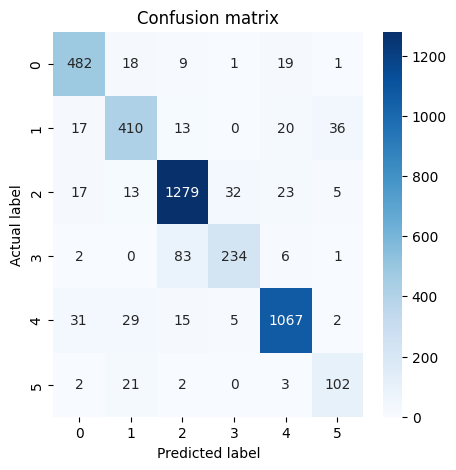

In [36]:
plot_confusion_matrix(y_test, preds)

In [37]:
def predict_emotion(text, model):
    text = clean_text(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=100)
    pred = model.predict(text)
    pred = pred.argmax(axis=1)
    return label_encoder.inverse_transform(pred)[0]

In [38]:
predict_emotion("I am so happy today!", model)

1/1 [==============================] - 0s 331ms/step


'joy'

In [39]:
predict_emotion("I am so sad today!", model)

1/1 [==============================] - 0s 36ms/step


'sadness'

In [40]:
# surprise
predict_emotion("Wow i was so unaware of the news!", model)

1/1 [==============================] - 0s 38ms/step


'anger'

In [41]:
predict_emotion("I am so furious today!", model)

1/1 [==============================] - 0s 38ms/step


'anger'

In [42]:
predict_emotion("It was so unfortunate that I lost my job today!", model)

1/1 [==============================] - 0s 38ms/step


'sadness'

In [43]:
emotions_data_2 = pd.read_csv("../data/emotions.csv")

In [44]:
# love data 
love_data = emotions_data_2[emotions_data_2["label"] == "love"]

In [45]:
a = love_data["text"].iloc[100]
b = love_data["label"].iloc[100]
a,b 

('i had to have a blood test yesterday so perhaps im feeling particularly fond of it right now because of the doctors needle that was inside of me and the time spent with the dizzy head of a non meat eating nineteen year old female',
 'love')

In [46]:
predict_emotion(a, model), b

1/1 [==============================] - 0s 40ms/step


('love', 'love')

## Data augmentation


https://www.analyticsvidhya.com/blog/2022/02/text-data-augmentation-in-natural-language-processing-with-texattack/


https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28

In [47]:
from textattack.augmentation import WordNetAugmenter

/Users/Cyrille/Documents/aiml22/Deep learning/deep_learning_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
word_aug = WordNetAugmenter()

[nltk_data] Downloading package omw-1.4 to /Users/Cyrille/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [49]:
word_aug.augment(a)

['i had to have a blood test yesterday so perhaps im notion particularly fond of it right now because of the fix needle that was inside of me and the time fatigued with the dizzy head of a non marrow eating nineteen year old female']

https://textattack.readthedocs.io/en/latest/2notebook/3_Augmentations.html

In [50]:
import pandas as pd

def augment_data(label, input_data):
    # Filter the DataFrame for the specified label
    data = input_data[input_data["label"] == label]

    # Create a list to store augmented rows
    augmented_rows = []

    # Loop through each text in the data
    for _, row in data.iterrows():
        
        # Generate augmented texts and add them as new rows
        for aug_text in word_aug.augment(row['text']):
            new_row = row.copy()
            new_row['text'] = aug_text
            augmented_rows.append(new_row)

    # Convert the list of rows into a DataFrame
    augmented_data = pd.DataFrame(augmented_rows, columns=data.columns)
    
    updated_emotions_data = pd.concat([input_data, augmented_data], ignore_index=True)

    return updated_emotions_data




In [51]:
train_data, test_data = train_test_split(emotions_data_2, test_size=0.2, random_state = 42)

In [52]:
train_data.shape, test_data.shape

((16000, 2), (4000, 2))

In [53]:
data2 = augment_data("love", train_data)

In [54]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17315 entries, 0 to 17314
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17315 non-null  object
 1   label   17315 non-null  object
dtypes: object(2)
memory usage: 270.7+ KB


In [55]:
data2["label"].value_counts()

label
joy         5392
sadness     4648
love        2630
anger       2179
fear        1877
surprise     589
Name: count, dtype: int64

In [56]:
data3 = augment_data("surprise", data2)

In [57]:
data3["label"].value_counts()

label
joy         5392
sadness     4648
love        2630
anger       2179
fear        1877
surprise    1178
Name: count, dtype: int64

In [58]:
data4 = augment_data("surprise", data3)

In [59]:
data4["label"].value_counts()

label
joy         5392
sadness     4648
love        2630
surprise    2356
anger       2179
fear        1877
Name: count, dtype: int64

In [60]:
data5 = augment_data("anger", data4)

In [61]:
data5["label"].value_counts()

label
joy         5392
sadness     4648
anger       4358
love        2630
surprise    2356
fear        1877
Name: count, dtype: int64

In [62]:
data6 = augment_data("fear", data5)

In [63]:
data6["label"].value_counts()

label
joy         5392
sadness     4648
anger       4358
fear        3754
love        2630
surprise    2356
Name: count, dtype: int64

In [64]:
data7 = augment_data("surprise", data6)

In [65]:
data7["label"].value_counts()

label
joy         5392
surprise    4712
sadness     4648
anger       4358
fear        3754
love        2630
Name: count, dtype: int64

In [66]:
data8 = augment_data("love", data7)

In [67]:
data8['label'].value_counts()

label
joy         5392
love        5260
surprise    4712
sadness     4648
anger       4358
fear        3754
Name: count, dtype: int64

In [68]:
data8.shape

(28124, 2)

In [69]:
data8["text"] = data8["text"].apply(clean_text)

In [70]:
data8.head()

,text,label
0,feel helpless goal reach nothing achieve,fear
1,went lecture cancelled,anger
2,feel combination slightly superior sitting vir...,joy
3,seem see five year chinese pavilion content ex...,sadness
4,feel like intelligent enough teacher,joy


In [71]:
count_vectorizer_1 = CountVectorizer()
vectorizer = count_vectorizer_1.fit_transform(data8["text"])
vectorizer.shape

(28124, 16199)

In [72]:
texts2 = data8["text"].tolist()
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(texts2)

word_index2 = tokenizer2.word_index
print('Found %s unique tokens.' % len(word_index2))

Found 16219 unique tokens.


In [73]:
data8["text"] = data8["text"].apply(lambda x: tokenizer2.texts_to_sequences([x])[0])

In [74]:
test_data["text"] = test_data["text"].apply(clean_text)

In [75]:
test_data["text"] = test_data["text"].apply(lambda x: tokenizer2.texts_to_sequences([x])[0])

In [76]:
test_data.head()

,text,label
10650,"[234, 448, 1, 129]",love
2041,"[263, 181, 831, 2, 824]",sadness
8668,"[261, 273, 2, 506, 1983, 6, 43, 1690]",joy
1114,"[174, 167, 1, 1931, 2]",sadness
13902,"[146, 622, 554, 512, 146, 5127, 696, 1, 304, 3...",anger


In [77]:
data8.head()

,text,label
0,"[1, 242, 901, 662, 161, 2419]",fear
1,"[229, 2420, 8127]",anger
2,"[1, 2530, 202, 805, 431, 5009, 634, 1, 137, 12...",joy
3,"[284, 43, 1164, 39, 2531, 6967, 496, 3301, 110...",sadness
4,"[1, 3, 849, 81, 946]",joy


In [78]:
X2, y2 = data8["text"], data8["label"]

In [79]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2, random_state = 42)

In [80]:
x_test2, y_test2 = test_data["text"], test_data["label"]

In [81]:
x_test2[:2], y_test2[:2]

(10650         [234, 448, 1, 129]
 2041     [263, 181, 831, 2, 824]
 Name: text, dtype: object,
 10650       love
 2041     sadness
 Name: label, dtype: object)

In [82]:
x_train2 = pad_sequences(x_train2, maxlen=120)
x_test2 = pad_sequences(x_test2, maxlen=120)
x_val2 = pad_sequences(x_val2, maxlen=120)

In [83]:
y_train2[:2], y_test2[:2], y_val2[:2]

(25884        love
 14515    surprise
 Name: label, dtype: object,
 10650       love
 2041     sadness
 Name: label, dtype: object,
 22643        fear
 23607    surprise
 Name: label, dtype: object)

In [84]:
label_encoder2 = LabelEncoder()

y_train_encoded2 = label_encoder2.fit_transform(y_train2)
y_test_encoded2 = label_encoder2.transform(y_test2)
y_val_encoded2 = label_encoder2.transform(y_val2)

y_train2 = to_categorical(y_train_encoded2)
y_test2 = to_categorical(y_test_encoded2)
y_val2 = to_categorical(y_val_encoded2)

In [85]:
y_train_encoded2[:10], y_test_encoded2[:10], y_val_encoded2[:10]

(array([3, 5, 5, 2, 3, 2, 5, 3, 0, 5]),
 array([3, 4, 2, 4, 0, 2, 3, 5, 4, 1]),
 array([1, 5, 3, 5, 4, 5, 0, 2, 5, 0]))

In [86]:
model2 = build_model(word_index2)  

In [87]:
x_train2.shape, y_train2.shape

((22499, 120), (22499, 6))

In [88]:
x_val2.shape, y_val2.shape

((5625, 120), (5625, 6))

In [89]:
history2 = model2.fit(x_train2, y_train2, epochs=10, batch_size=128,validation_data=(x_val2, y_val2),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10


176/176 [==============================] - 83s 449ms/step - loss: 1.2139 - accuracy: 0.5488 - val_loss: 0.4879 - val_accuracy: 0.8553
Epoch 2/10
176/176 [==============================] - 78s 444ms/step - loss: 0.2483 - accuracy: 0.9281 - val_loss: 0.2349 - val_accuracy: 0.9236
Epoch 3/10
176/176 [==============================] - 78s 444ms/step - loss: 0.0941 - accuracy: 0.9717 - val_loss: 0.2087 - val_accuracy: 0.9300
Epoch 4/10
176/176 [==============================] - 78s 445ms/step - loss: 0.0569 - accuracy: 0.9831 - val_loss: 0.2220 - val_accuracy: 0.9358
Epoch 5/10
176/176 [==============================] - 83s 470ms/step - loss: 0.0405 - accuracy: 0.9882 - val_loss: 0.2161 - val_accuracy: 0.9365
Epoch 6/10
176/176 [==============================] - 83s 469ms/step - loss: 0.0297 - accuracy: 0.9909 - val_loss: 0.2166 - val_accuracy: 0.9358


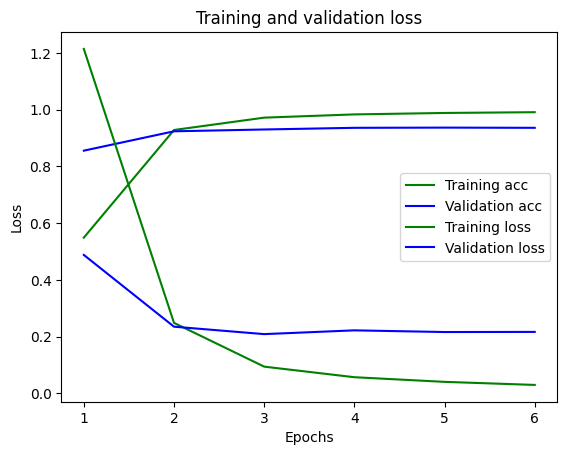

In [90]:
plot_history(history2)

In [91]:
model2.evaluate(x_test2, y_test2)

125/125 [==============================] - 3s 26ms/step - loss: 0.3815 - accuracy: 0.8985


[0.3814832270145416, 0.8985000252723694]

In [92]:
y_test2 = y_test2.argmax(axis=1)

In [94]:
preds2 = model2.predict(x_test2)

125/125 [==============================] - 4s 28ms/step


In [96]:
preds2 = preds2.argmax(axis=1)

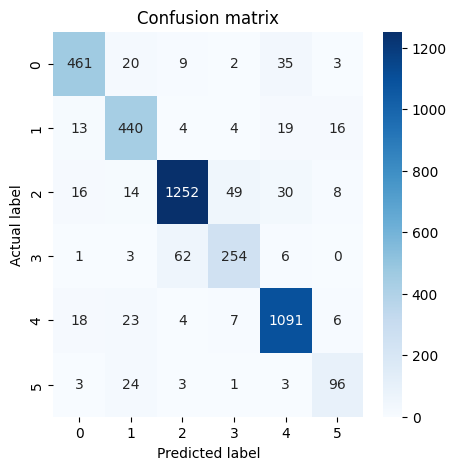

In [97]:
plot_confusion_matrix(y_test2, preds2)

In [98]:
predict_emotion("Wow i was so unaware of the news!", model2)

1/1 [==============================] - 0s 361ms/step


'anger'